In [8]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from skimage import io, color, filters, morphology, measure, segmentation, exposure
from skimage.feature import peak_local_max
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.measure import regionprops, label
from scipy import ndimage as ndi
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from skimage.transform import resize
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


In [1]:

for dirname, _, filenames in os.walk('/kaggle/input/breakhis/BreaKHis 400X'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/breakhis/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-019.png
/kaggle/input/breakhis/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-027.png
/kaggle/input/breakhis/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-025.png
/kaggle/input/breakhis/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-005.png
/kaggle/input/breakhis/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-003.png
/kaggle/input/breakhis/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-028.png
/kaggle/input/breakhis/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-011.png
/kaggle/input/breakhis/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-015.png
/kaggle/input/breakhis/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-001.png
/kaggle/input/breakhis/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-004.png
/kaggle/input/breakhis/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-007.png
/kaggle/input/breakhis/BreaKHis 400X/test/malignant/SOB_M_DC-14-2773-400-013.png
/kaggle/input/breakhis/BreaKHis 400X/te

# Segment Nuclei

In [4]:


# ----------------- SEGMENTATION -----------------
def segment_nuclei_fixed(
    img_rgb: np.ndarray,
    close_radius: int = 1,
    min_area: int = 50,
    max_area: int = 4000,
    delta_h: float = 0.03,
    watershed_min_distance: int = 7,
):
    """
    HED->H channel -> (Otsu - delta_h) threshold -> cleanup ->
    distance-based watershed to split big/touching blobs -> shape/area filter.
    """
    if img_rgb.ndim == 3 and img_rgb.shape[-1] == 4:
        img_rgb = img_rgb[:, :, :3]

    # HED deconvolution and use H channel (nuclei)
    H = color.rgb2hed(img_rgb)[:, :, 0]
    H = exposure.rescale_intensity(H, in_range="image", out_range=(0, 1))

    # --- (1) lower threshold slightly to catch faint nuclei ---
    t = filters.threshold_otsu(H)
    thr = max(0.0, min(1.0, t - float(delta_h)))
    nuclei = H > thr

    # --- cleanup ---
    if close_radius > 0:
        nuclei = morphology.binary_closing(nuclei, morphology.disk(close_radius))
    nuclei = morphology.remove_small_holes(nuclei, area_threshold=32)
    nuclei = morphology.remove_small_objects(nuclei, min_size=max(25, min_area // 2))

    # --- (2) watershed to split close/large blobs ---
    distance = ndi.distance_transform_edt(nuclei)
    coords = peak_local_max(
        distance,
        footprint=np.ones((2 * watershed_min_distance + 1, 2 * watershed_min_distance + 1)),
        labels=nuclei,
        exclude_border=False,
    )
    markers = np.zeros_like(distance, dtype=int)
    for i, (r, c) in enumerate(coords, start=1):
        markers[r, c] = i
    markers = ndi.label(markers)[0]
    labels_ws = segmentation.watershed(-distance, markers, mask=nuclei)

    # --- area + light shape gate (avoid fibers/noise) ---
    keep = np.zeros_like(labels_ws, dtype=bool)
    for r in measure.regionprops(labels_ws):
        if not (min_area <= r.area <= max_area):
            continue
        if r.solidity < 0.80 or r.eccentricity > 0.98:
            continue
        keep[labels_ws == r.label] = True

    labels = measure.label(keep)
    regions = measure.regionprops(labels)
    return labels, regions

def extract_and_save_nucleus_patches(DIR, out_dir, patch_size=81, min_area=50, max_area=4000, delta_h=0.03, watershed_min_distance=7):
    """
    Load images from DIR, detect nuclei using friend's method, crop patch_size x patch_size patches around each nucleus centroid,
    enhance contrast, and save them to out_dir with naming image_name-nucleus_num.png.
    """
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    half_patch = patch_size // 2
    
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR, IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = io.imread(PATH)
            if img.ndim == 3 and img.shape[-1] == 4:
                img = img[:, :, :3]
            if img.dtype != np.uint8:
                img = (255 * (img.astype(np.float32) / max(1, img.max()))).astype(np.uint8)
            
            labels, regions = segment_nuclei_fixed(
                img,
                close_radius=1,
                min_area=min_area,
                max_area=max_area,
                delta_h=delta_h,
                watershed_min_distance=watershed_min_distance,
            )
            
            image_base = IMAGE_NAME.split('.')[0]
            nucleus_num = 0
            for r in regions:
                cy, cx = map(int, [round(coord) for coord in r.centroid])  # Round each centroid coordinate
                y_start = max(0, cy - half_patch)
                y_end = min(img.shape[0], cy + half_patch + (patch_size % 2))
                x_start = max(0, cx - half_patch)
                x_end = min(img.shape[1], cx + half_patch + (patch_size % 2))
                
                if (y_end - y_start) == patch_size and (x_end - x_start) == patch_size:
                    nucleus_num += 1
                    patch = img[y_start:y_end, x_start:x_end]
                    
                    # Enhance contrast for better visibility
                    patch_gray = cv2.cvtColor(patch, cv2.COLOR_RGB2GRAY)
                    patch_enhanced = (equalize_hist(patch_gray) * 255).astype(np.uint8)
                    patch_rgb = cv2.cvtColor(patch_enhanced, cv2.COLOR_GRAY2RGB)
                    
                    save_path = os.path.join(out_dir, f"{image_base}-nucleus_{nucleus_num}.png")
                    io.imsave(save_path, patch_rgb)

# Define output directories
base_out = '/kaggle/working/nucleus_patches'
train_benign_out = os.path.join(base_out, 'train', 'benign')
train_malignant_out = os.path.join(base_out, 'train', 'malignant')
test_benign_out = os.path.join(base_out, 'test', 'benign')
test_malignant_out = os.path.join(base_out, 'test', 'malignant')

# Apply to all four categories
extract_and_save_nucleus_patches('/kaggle/input/breakhis/BreaKHis 400X/train/benign', train_benign_out, patch_size=81)
extract_and_save_nucleus_patches('/kaggle/input/breakhis/BreaKHis 400X/train/malignant', train_malignant_out, patch_size=81)
extract_and_save_nucleus_patches('/kaggle/input/breakhis/BreaKHis 400X/test/benign', test_benign_out, patch_size=81)
extract_and_save_nucleus_patches('/kaggle/input/breakhis/BreaKHis 400X/test/malignant', test_malignant_out, patch_size=81)



100%|██████████| 11/11 [00:05<00:00,  1.96it/s]


# Visualize some saved patches

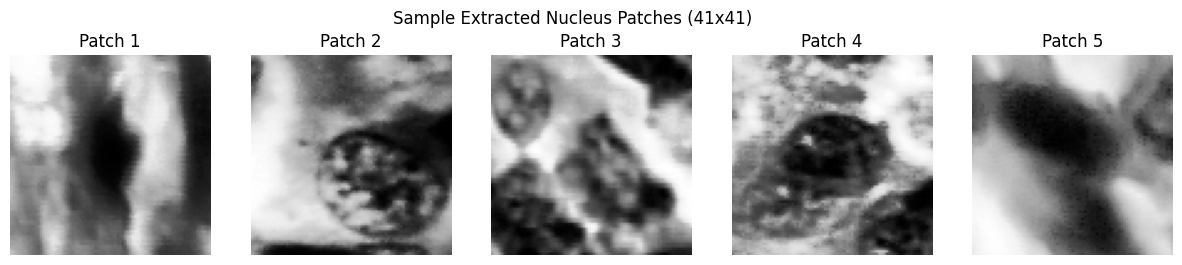

In [5]:

sample_patches = []
sample_dir = test_malignant_out
if os.path.exists(sample_dir):
    patch_files = [f for f in os.listdir(sample_dir) if f.endswith('.png')]
    for fname in patch_files[15:20]:  # Take first 5 patches
        patch_path = os.path.join(sample_dir, fname)
        patch = io.imread(patch_path)
        sample_patches.append(patch)

if sample_patches:
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for j, patch in enumerate(sample_patches):
        axes[j].imshow(patch)
        axes[j].set_title(f"Patch {j+1}")
        axes[j].axis('off')
    plt.suptitle("Sample Extracted Nucleus Patches (41x41)")
    plt.show()
else:
    print("No patches found to display. Check if patches were saved in:", sample_dir)

# Create labels and splitted into train test and validation

In [25]:


# Function to load patches with resizing if needed
def load_patches(directory, target_size=(81, 81)):
    patches = []
    for fname in os.listdir(directory):
        if fname.endswith('.png'):
            patch_path = os.path.join(directory, fname)
            patch = io.imread(patch_path)
            # Resize to target size if not already
            if patch.shape[:2] != target_size:
                patch = resize(patch, (*target_size, 3), mode='constant', preserve_range=True, anti_aliasing=True).astype(np.uint8)
            patches.append(patch)
    return np.array(patches)

# Load patches
train_benign_patches = load_patches(train_benign_out)
train_malignant_patches = load_patches(train_malignant_out)
test_benign_patches = load_patches(test_benign_out)
test_malignant_patches = load_patches(test_malignant_out)

# Create labels
benign_train_label = np.zeros(len(train_benign_patches))
malign_train_label = np.ones(len(train_malignant_patches))
benign_test_label = np.zeros(len(test_benign_patches))
malign_test_label = np.ones(len(test_malignant_patches))

label_dict = {0: "benign", 1: "malignant"}

# Merge data
X_train = np.concatenate((train_benign_patches, train_malignant_patches), axis=0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis=0)
X_test = np.concatenate((test_benign_patches, test_malignant_patches), axis=0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis=0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes=2)
Y_test = to_categorical(Y_test, num_classes=2)

# Split train data into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

# Optional: Print shapes to verify
print("X_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (2023, 81, 81, 3)
y_train shape: (2023, 2)
x_val shape: (506, 81, 81, 3)
y_val shape: (506, 2)
X_test shape: (735, 81, 81, 3)
Y_test shape: (735, 2)


# Extract Handcrafted Feature

In [54]:


def extract_handcrafted_features(images):
    handcrafted_features = []
    
    for img in images:
        # Convert to grayscale for GLCM and shape features
        gray_img = rgb2gray(img)
        
        # 1. Haralick Features using GLCM (Texture)
        # Compute GLCM with distances [1] and angles [0, np.pi/4, np.pi/2, 3*np.pi/4]
        glcm = graycomatrix(np.uint8(gray_img * 255), 
                           distances=[1], 
                           angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], 
                           levels=256, 
                           symmetric=True, 
                           normed=True)
        # Extract Haralick features: contrast, correlation, energy, homogeneity
        contrast = graycoprops(glcm, 'contrast').ravel()
        correlation = graycoprops(glcm, 'correlation').ravel()
        energy = graycoprops(glcm, 'energy').ravel()
        homogeneity = graycoprops(glcm, 'homogeneity').ravel()
        texture_features = np.concatenate([contrast, correlation, energy, homogeneity])
        
        # 2. Shape Features
        # Binarize the image and label regions
        binary_img = gray_img > np.mean(gray_img)  # Simple threshold based on mean
        labeled_img = label(binary_img)
        props = regionprops(labeled_img, intensity_image=gray_img)
        if props:
            prop = props[0]  # Take the largest region
            area = prop.area
            perimeter = prop.perimeter
            eccentricity = prop.eccentricity
            shape_features = np.array([area, perimeter, eccentricity])
        else:
            shape_features = np.array([0, 0, 0])  # Default if no regions found
        
        # 3. Color Features (RGB Histogram)
        # Compute histogram for each channel
        hist_r = np.histogram(img[:,:,0], bins=256, range=(0, 255))[0]
        hist_g = np.histogram(img[:,:,1], bins=256, range=(0, 255))[0]
        hist_b = np.histogram(img[:,:,2], bins=256, range=(0, 255))[0]
        color_features = np.concatenate([hist_r[:50], hist_g[:50], hist_b[:50]])  # Use top 50 bins per channel
        
        # Combine all features
        all_features = np.concatenate([texture_features, shape_features, color_features])
        handcrafted_features.append(all_features)
    
    return np.array(handcrafted_features)

# Extract handcrafted features for train, val, and test sets
hand_features_train = extract_handcrafted_features(x_train)
hand_features_val = extract_handcrafted_features(x_val)
hand_features_test = extract_handcrafted_features(X_test)


print(f"Total Features Extracted Per nuclues patch: {hand_features_test.shape[1]}")


Total Features Extracted Per nuclues patch: 169


# Extract Deep Features


In [55]:

# Load VGG19 model with local weights, excluding the top (classification) layers
base_model = VGG19(weights='/kaggle/input/vgg19/keras/default/1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                  include_top=False, 
                  input_shape=(224, 224, 3))

# Create a model that outputs features from the last convolutional layer
feature_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

def extract_deep_features(images):
    # Resize images to 224x224
    resized_images = np.array([resize(img, (224, 224, 3), mode='constant', preserve_range=True, anti_aliasing=True) for img in images])
    # Preprocess images for VGG19 (normalize and format)
    processed_images = preprocess_input(resized_images)
    # Extract features
    features = feature_extractor.predict(processed_images, batch_size=32, verbose=1)
    # Flatten the features to 1D vectors
    features_flat = features.reshape(features.shape[0], -1)
    return features_flat

# Extract deep features for train, val, and test sets
deep_features_train = extract_deep_features(x_train)
deep_features_val = extract_deep_features(x_val)
deep_features_test = extract_deep_features(X_test)


print(f"Total Features Extracted Per nuclues patch: {deep_features_test.shape[1]}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 752s 12s/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 177s 11s/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 255s 11s/step
Total Features Extracted Per nuclues patch: 25088


# Deep fearures reduction using PCA

In [56]:

# Initialize PCA to reduce to 512 components
pca = PCA(n_components=512)

# Fit PCA(On training data only to avoid data leakage
pca.fit(deep_features_train)

# Transform the training, validation, and test features
deep_features_train_pca = pca.transform(deep_features_train)
deep_features_val_pca = pca.transform(deep_features_val)
deep_features_test_pca = pca.transform(deep_features_test)


print(f"PCA-reduced feature: {deep_features_train_pca.shape[1]}")



PCA-reduced feature: 512


# fusion two type features using SVM and K fold cross validation

In [30]:

# Fuse handcrafted and deep features
fused_features_train = np.concatenate([hand_features_train, deep_features_train_pca], axis=1)
fused_features_val = np.concatenate([hand_features_val, deep_features_val_pca], axis=1)
fused_features_test = np.concatenate([hand_features_test, deep_features_test_pca], axis=1)

# Standardize fused features (important for SVM)
scaler = StandardScaler()
fused_features_train = scaler.fit_transform(fused_features_train)  # Fit and transform on training data
fused_features_val = scaler.transform(fused_features_val)        # Transform validation data
fused_features_test = scaler.transform(fused_features_test)      # Transform test data

# Convert one-hot encoded labels back to single labels for SVM
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)
y_test_labels = np.argmax(Y_test, axis=1)

# Define parameter grid for SVM
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'gamma': ['scale', 'auto', 0.001, 0.01],
    'class_weight': [None, 'balanced']  # Handle potential class imbalance
}

# Initialize SVM classifier
svm_classifier = SVC(kernel='rbf', random_state=42)

# Perform 5-fold cross-validation with grid search on fused training features
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_search.fit(fused_features_train, y_train_labels)

# Print best parameters and cross-validation score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation F1-Score: {grid_search.best_score_:.4f}")

# Use the best model for predictions
svm_classifier = grid_search.best_estimator_

# Predict on validation and test sets
y_val_pred = svm_classifier.predict(fused_features_val)
y_test_pred = svm_classifier.predict(fused_features_test)

# Calculate metrics for validation set
val_accuracy = accuracy_score(y_val_labels, y_val_pred)
val_precision = precision_score(y_val_labels, y_val_pred, average='weighted')
val_recall = recall_score(y_val_labels, y_val_pred, average='weighted')
val_f1 = f1_score(y_val_labels, y_val_pred, average='weighted')

# Calculate metrics for test set
test_accuracy = accuracy_score(y_test_labels, y_test_pred)
test_precision = precision_score(y_test_labels, y_test_pred, average='weighted')
test_recall = recall_score(y_test_labels, y_test_pred, average='weighted')
test_f1 = f1_score(y_test_labels, y_test_pred, average='weighted')

# Print results
print("Validation Set Metrics:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1-Score: {val_f1:.4f}")
print("\nTest Set Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print("\nDetailed Classification Report for Test Set:")
print(classification_report(y_test_labels, y_test_pred, target_names=['benign', 'malignant']))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'C': 1.0, 'class_weight': 'balanced', 'gamma': 0.001}
Best Cross-Validation F1-Score: 0.8468
Validation Set Metrics:
Accuracy: 0.8696
Precision: 0.8812
Recall: 0.8696
F1-Score: 0.8714

Test Set Metrics:
Accuracy: 0.8735
Precision: 0.8848
Recall: 0.8735
F1-Score: 0.8752

Detailed Classification Report for Test Set:
              precision    recall  f1-score   support

      benign       0.78      0.92      0.84       269
   malignant       0.95      0.85      0.89       466

    accuracy                           0.87       735
   macro avg       0.86      0.88      0.87       735
weighted avg       0.88      0.87      0.88       735



# Visualize the patch image from X_test

Patch Index: 25
True Label: 0 (benign)
Predicted Label: 1 (malignant)
Correct Prediction: False


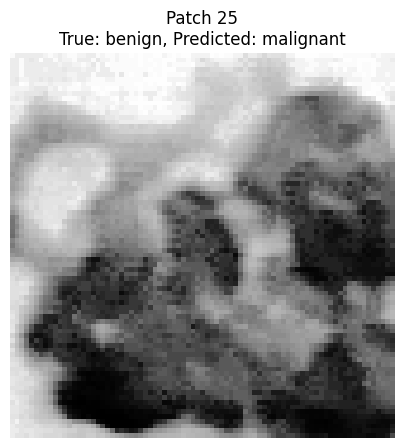

In [50]:

# Define class names for readability
class_names = ['benign', 'malignant']

# Specify the index of the patch you want to inspect (e.g., 0 to 884)
patch_index = 25 # Change this to inspect a different patch

# Check if the index is valid
if patch_index < 0 or patch_index >= len(y_test_labels):
    print(f"Error: patch_index {patch_index} is out of range. Choose an index between 0 and {len(y_test_labels)-1}.")
else:
    # Get true and predicted labels
    true_label = y_test_labels[patch_index]
    predicted_label = y_test_pred[patch_index]

    # Convert numeric labels to class names
    true_class = class_names[true_label]
    predicted_class = class_names[predicted_label]

    # Print results
    print(f"Patch Index: {patch_index}")
    print(f"True Label: {true_label} ({true_class})")
    print(f"Predicted Label: {predicted_label} ({predicted_class})")
    print(f"Correct Prediction: {true_label == predicted_label}")

    # Optional: Visualize the patch image from X_test (if available)
    try:
        patch_image = X_test[patch_index]  # Assumes X_test contains the original images
        plt.figure(figsize=(5, 5))
        plt.imshow(patch_image)
        plt.title(f"Patch {patch_index}\nTrue: {true_class}, Predicted: {predicted_class}")
        plt.axis('off')
        plt.show()
    except NameError:
        print("Visualization skipped: X_test is not defined or accessible.")

Patch Index: 16
True Label: 1 (malignant)
Predicted Label: 1 (malignant)
Correct Prediction: True


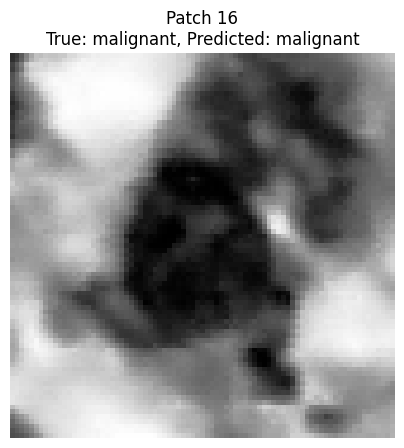

In [20]:

# Define class names for readability
class_names = ['benign', 'malignant']

# Specify the index of the patch you want to inspect (e.g., 0 to 884)
patch_index =  16 # Change this to inspect a different patch

# Check if the index is valid
if patch_index < 0 or patch_index >= len(y_test_labels):
    print(f"Error: patch_index {patch_index} is out of range. Choose an index between 0 and {len(y_test_labels)-1}.")
else:
    # Get true and predicted labels
    true_label = y_test_labels[patch_index]
    predicted_label = y_test_pred[patch_index]

    # Convert numeric labels to class names
    true_class = class_names[true_label]
    predicted_class = class_names[predicted_label]

    # Print results
    print(f"Patch Index: {patch_index}")
    print(f"True Label: {true_label} ({true_class})")
    print(f"Predicted Label: {predicted_label} ({predicted_class})")
    print(f"Correct Prediction: {true_label == predicted_label}")

    # Optional: Visualize the patch image from X_test (if available)
    try:
        patch_image = X_test[patch_index]  # Assumes X_test contains the original images
        plt.figure(figsize=(5, 5))
        plt.imshow(patch_image)
        plt.title(f"Patch {patch_index}\nTrue: {true_class}, Predicted: {predicted_class}")
        plt.axis('off')
        plt.show()
    except NameError:
        print("Visualization skipped: X_test is not defined or accessible.")